In [ ]:
import numpy as np
from skimage.io import imread
from pathlib import Path
import sys 
import os.path
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
import cv2
import skimage
import os
import logging
from itertools import cycle
from scipy import ndimage as ndi
from matplotlib.pyplot import gca
from sklearn.cluster import KMeans

# Part 1: Data labeling: Generate ground truth for the images given

# Original Image and Ground_truth 

Image number to be segmented between 1 to 10:7


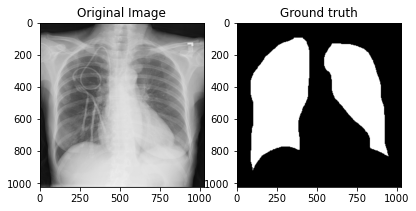

In [ ]:
list_img_names =  sorted(Path.cwd().glob('28/testing_data/*.png'))
list_gtimg_names =  sorted(Path.cwd().glob('28/testing_gt/*.png'))

img_no=input("Image number to be segmented between 1 to 10:")
img_no=int(img_no)-1
Original_Image=plt.imread(str(list_img_names[img_no]))
Ground_truth=plt.imread(str(list_gtimg_names[img_no]))
Ground_truth=255*np.uint8(Ground_truth==1)
gt_img=Ground_truth[:,:,0]

kernel1 =cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))   # varry the kernel size to obtain the desired edges
opening1 = cv2.morphologyEx(gt_img, cv2.MORPH_OPEN, kernel1)
filterSize =(1,1) 
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)
gt_img_dilation = cv2.dilate(gt_img,kernel1,iterations = 1)
filterSize =(3,3) 
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)
gt_img_closing = cv2.morphologyEx(gt_img_dilation, cv2.MORPH_CLOSE, kernel1)

# ####Contour from training data set ###########
# list_training_output =  sorted(Path.cwd().glob('output\initial_contour\*asm.png'))
# initial_level_set_tr=plt.imread(str(list_training_output[0]))


#Display results
display = [Original_Image,gt_img_closing]
label = ['Original Image','Ground truth']
fig = plt.figure(figsize=(10,10))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig.add_subplot(2,3, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

# Mean shape calculation using training data

In [ ]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
import numpy as np


def load_landmarks(dirname='./28/training_gt',num_pts=40,num_obj=2):

    file_list=glob.glob(os.path.join(dirname,"*.png"))

    num_subj = len(file_list)
    inputList = np.zeros((num_subj,num_obj, num_pts, 2))

    for i, files in enumerate(file_list):
        img = plt.imread(files)[:,:,0]
        seg_map=(img==1).astype('float32')
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)) 
        dilate = cv2.dilate(seg_map,kernel_dilate,iterations = 1)

        contours, hierarchy = cv2.findContours((dilate*255).astype('uint8'),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        left_lung = np.array(contours[1][:,0,:])
        right_lung = np.array(contours[0][:,0,:])

        left_interval = left_lung.shape[0]//num_pts
        right_interval = right_lung.shape[0]//num_pts

        left_cord = np.array([left_lung[i*left_interval,:] for i in range(0,num_pts)]).reshape((num_pts,2))
        right_cord = np.array([right_lung[i*right_interval,:] for i in range(0,num_pts)]).reshape((num_pts,2))

        inputList[i,0,:,:]= left_cord
        inputList[i,1,:,:]= right_cord
    return inputList



def mean_landmarks(landmarks):
    return np.mean(landmarks,0)
    
def procrustes_analysis(landmarks):
    
    mean = np.mean(landmarks,0)
    landmarks_std = np.empty_like(landmarks)
    
    for i, landmark in enumerate(landmarks):
        
        mean_std, landmark_std, disp = procrustes(mean, landmark)
        landmarks_std[i] = landmark_std
    
    return landmarks_std

def total_procrustes_analysis(all_landmarks):
    #allign shapes in their set
    
    all_landmarks = np.transpose(all_landmarks, (1,0,2,3))
    all_landmarks_std = np.empty_like(all_landmarks)
    
    for i, landmarks in enumerate(all_landmarks):
        
        landmarks_std = procrustes_analysis(landmarks)
        all_landmarks_std[i] = landmarks_std
        
    all_landmarks_std = np.transpose(all_landmarks_std, (1,0,2,3))
    return all_landmarks_std

    
######### Visualization #########

def show(img):

    plt.imshow(img)
    plt.show()
        
def show_land_mark(landmarks,img_dirname,with_img=True):
    file_list=glob.glob(os.path.join(img_dirname,"*.png"))
    plt.figure()
    n = len(landmarks)
    hn = int(n/2)
    fig, ax = plt.subplots(figsize=(15, 7))
   
    print('Showing Lungs Landmarks')

    for i, landmark in enumerate(landmarks):
        plt.subplot(2, hn, i+1)
        if(i!=hn):
            plt.xticks(())
            plt.yticks(())   
        plt.plot(landmark[:,0], landmark[:,1], 'go')
        plt.gca().invert_yaxis()
        if with_img:
            plt.imshow(plt.imread(file_list[i]),cmap='gray')
     
    plt.show()
    
def show_mean_land_mark(mean_landmark,img_dirname,with_img=True):
#def show_land_mark(landmarks,img_dirname,with_img=True):
    file_list=glob.glob(os.path.join(img_dirname,"*.png"))
    plt.figure()
    n = len(mean_landmark)
    hn = int(n/2)
    fig, ax = plt.subplots(figsize=(3, 3))
   
    print('Showing Lung Landmarks...')

    for i, landmark in enumerate(mean_landmark):
        plt.subplot(2, hn, i+1)
        if(i!=hn):
            plt.xticks(())
            plt.yticks(())   
        plt.plot(landmark[:,0], landmark[:,1], 'go')
        plt.gca().invert_yaxis()
        if with_img:
            plt.imshow(plt.imread(file_list[i]),cmap='gray')
     
    plt.show()



Showing Lungs Landmarks


<Figure size 432x288 with 0 Axes>

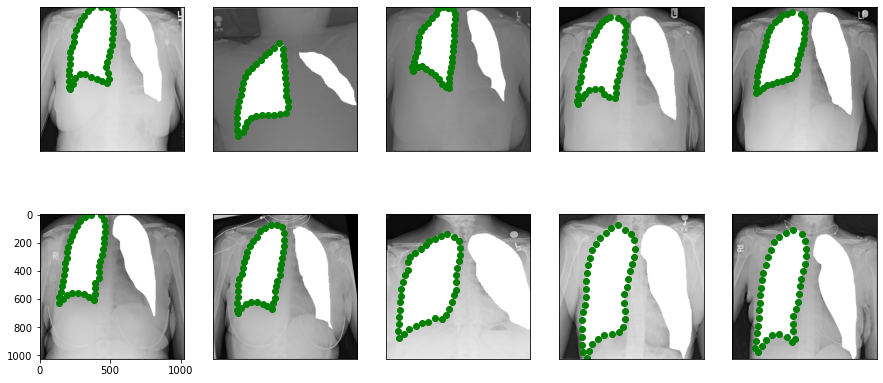

Showing Lungs Landmarks


<Figure size 432x288 with 0 Axes>

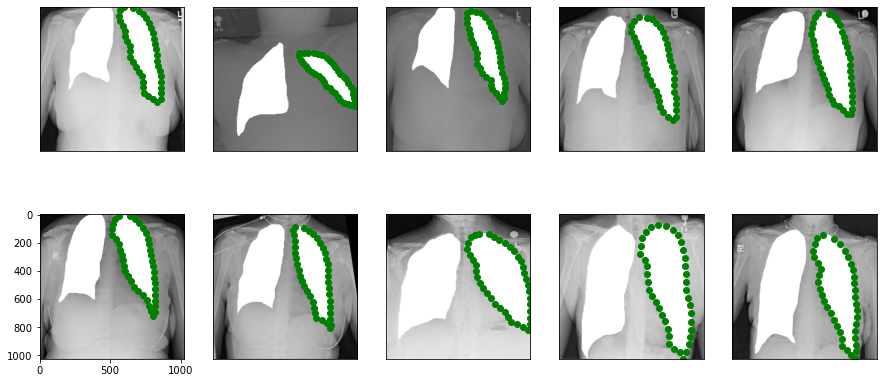

In [ ]:
dirname = "28/training_gt/*.png"
file_list=glob.glob(os.path.join(dirname,"*.png"))

all_landmarks = load_landmarks(dirname='./28/training_gt',num_pts=40,num_obj=2)

show_land_mark(all_landmarks[:,0,:,:],img_dirname='./28/training_gt',with_img=True)
show_land_mark(all_landmarks[:,1,:,:],img_dirname='./28/training_gt',with_img=True)
#plt.savefig('Output/train/%d/Contrst_Enhanced_Histogram_img.png'%int(img_no+1), bbox_inches='tight')
#savefig('output/initial_contour/landmarks.png', bbox_inches='tight')

Showing Lungs Landmarks


<Figure size 432x288 with 0 Axes>

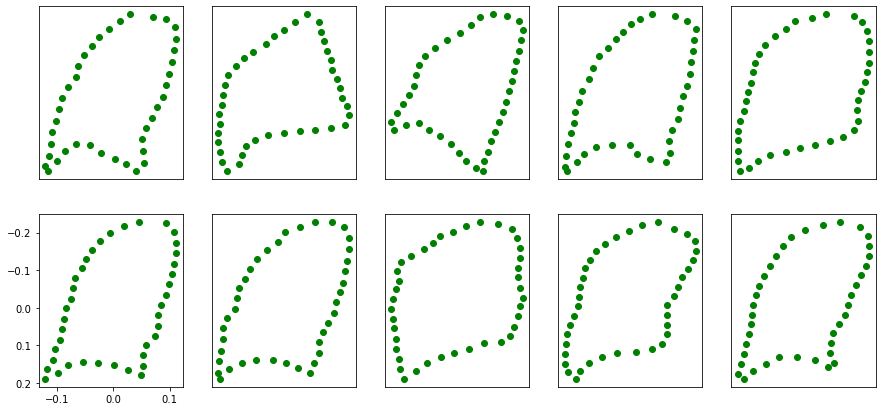

Showing Lung Landmarks...


<Figure size 432x288 with 0 Axes>

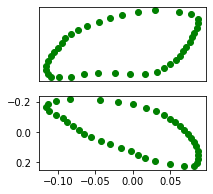

In [ ]:
all_landmarks_std = total_procrustes_analysis(all_landmarks)
show_land_mark(all_landmarks_std[:,0,:,:],img_dirname='./28/training_gt',with_img=False)
mean_landmark=np.zeros((all_landmarks_std[0,:,:].shape))
mean_landmark[0,:,:]=np.mean(all_landmarks_std[:,0,:,:],axis=0)
mean_landmark[1,:,:]=np.mean(all_landmarks_std[:,1,:,:],axis=0)

show_mean_land_mark(mean_landmark[:,:,:],img_dirname='./28/training_gt',with_img=False)
#fig.savefig('output/initial_contour/meanlandmarks.png', bbox_inches='tight')

In [ ]:
#####  Right_lung ####
x_center_r=int((np.min(all_landmarks[:,0,:,0])+np.max(all_landmarks[:,0,:,0]))/2)
y_center_r=int((np.min(all_landmarks[:,0,:,1])+np.max(all_landmarks[:,0,:,1]))/2)
x_mag_r=int((np.max(all_landmarks[:,0,:,0])-np.min(all_landmarks[:,0,:,0])))
y_mag_r=int((np.max(all_landmarks[:,0,:,1])-np.min(all_landmarks[:,0,:,1])))
print(x_mag_r,y_mag_r,np.min(all_landmarks[:,0,:,0]),np.max(all_landmarks[:,0,:,0]))

#### left lung #####
x_center_l=int((np.min(all_landmarks[:,1,:,0])+np.max(all_landmarks[:,1,:,0]))/2)
y_center_l=int((np.min(all_landmarks[:,1,:,1])+np.max(all_landmarks[:,1,:,1]))/2)
x_mag_l=int((np.max(all_landmarks[:,1,:,0])-np.min(all_landmarks[:,1,:,0])))
y_mag_l=int((np.max(all_landmarks[:,1,:,1])-np.min(all_landmarks[:,1,:,1])))
print(x_mag_l,y_mag_l,np.min(all_landmarks[:,1,:,0]),np.max(all_landmarks[:,1,:,0]))

453 1017 84.0 537.0
515 1023 508.0 1023.0


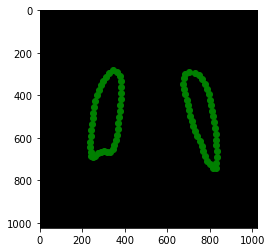

In [ ]:
######### right_lung #########
mean_landmark_modified=np.copy(mean_landmark)
mean_landmark_modified[0,:,0]=1.5*x_mag_r*(mean_landmark[0,:,0])+x_center_r
mean_landmark_modified[0,:,1]=y_mag_r*(mean_landmark[0,:,1])+y_center_r

######### left_lung #########
#mean_landmark_modified=np.copy(mean_landmark)
mean_landmark_modified[1,:,0]=1.5*x_mag_l*(mean_landmark[1,:,0])+x_center_l
mean_landmark_modified[1,:,1]=y_mag_l*(mean_landmark[1,:,1])+y_center_l

image=np.zeros((10,1024,1024))
for i, files in enumerate(file_list):
        img = plt.imread(files)[:,:,0]
        image[i,:,:]=img
plt.scatter(mean_landmark_modified[0,:,0],mean_landmark_modified[0,:,1],color='g')
plt.scatter(mean_landmark_modified[1,:,0],mean_landmark_modified[1,:,1],color='g')
plt.imshow(image[9],cmap='gray')

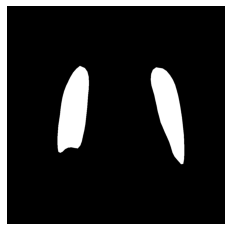

In [ ]:
p_uint=np.copy(mean_landmark_modified)
right=p_uint[0].astype(np.int32)
left=p_uint[1].astype(np.int32)
#contours =l #p_uint[0]#[:,0] , numpy.array([[99,99],[99,60],[60,99]], dtype=numpy.int32)]

drawing = np.zeros(image[0].shape,np.uint8)

# #for cnt in contours:
cv2.drawContours(drawing,[right,left],-1,(255,255,255),-1)
plt.imshow(drawing,cmap='gray')
plt.axis('off')
initial_level_set_tr=np.copy(drawing)
#plt.savefig("output/initial_contour/Initial active contour using asm.png", bbox_inches='tight')

# Histogram Equalisation based image enhancement

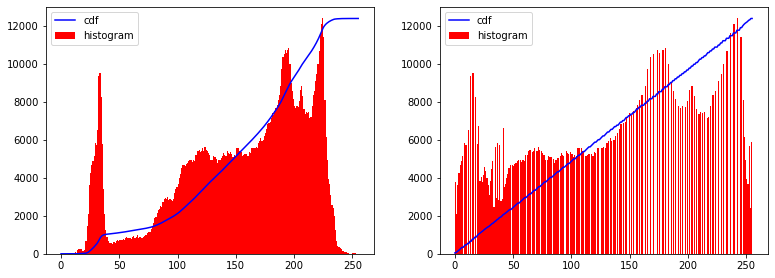

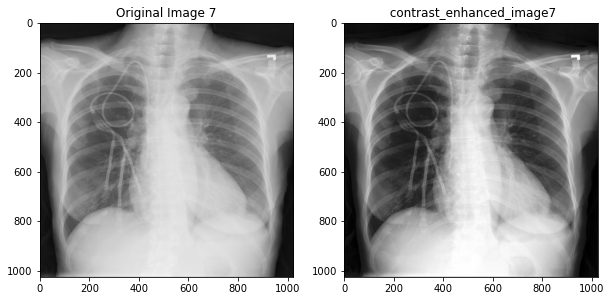

In [ ]:
img=np.uint(Original_Image*255)
grey_levels, count = np.unique(img, return_counts=True)
H = np.zeros((256,1))
for i in range(0,len(grey_levels)):
    H[grey_levels[i],0]=count[i]
cdf=[sum(H[:i+1]) for i in range(len(H))]
cdf=np.concatenate( cdf, axis=0 )
# print(cdf)
cdf_normalized = cdf * H.max()/ cdf.max()
# plt.plot(cdf_normalized, color = 'b')
# plt.hist(img.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')
# plt.show()
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m= (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

img_enhanced = cdf[img]
grey_levels_2, count_2 = np.unique(img_enhanced, return_counts=True)
H_2 = np.zeros((256,1))
for i in range(0,len(grey_levels_2)):
    H_2[grey_levels_2[i],0]=count_2[i]
cdf_2=[sum(H_2[:i+1]) for i in range(len(H_2))]
cdf_2=np.concatenate( cdf_2, axis=0 )
# print(cdf)
cdf_normalized_2 = cdf_2 * H_2.max()/ cdf_2.max()
fg = plt.figure("Regularised labeling",figsize=(20,10))
ax1 = fg.add_subplot(2,3,1)
ax1.plot(cdf_normalized, color = 'b')
ax1.hist(img.flatten(),256,[0,256], color = 'r')
#ax1.xlim([0,256])
ax1.legend(('cdf','histogram'), loc = 'upper left')
#plt.show()
ax2 = fg.add_subplot(2,3,2)
ax2.plot(cdf_normalized_2, color = 'b')
ax2.hist(img_enhanced.flatten(),256,[0,256], color = 'r')
#ax2.xlim([0,256])
ax2.legend(('cdf','histogram'), loc = 'upper left')
#plt.show()


display = [img, img_enhanced  ]
label = ['Original Image %d'%int(img_no+1), ' contrast_enhanced_image%d'%int(img_no+1)]

fig = plt.figure(figsize=(10,15))

for i in range(len(display)):
  fig.add_subplot(2, 2, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])
plt.show()


# fig.savefig('out/Part 2/Contrst_Enhanced_Histogram_img.png')
fg.savefig('Output/test/%d/Contrst_Enhanced_Histogram_img.png'%int(img_no+1), bbox_inches='tight')
fig.savefig('Output/test/%d/Contrst_Enhanced_image.png'%int(img_no+1), bbox_inches='tight')
# files.download('output/train/%d/Contrst_Enhanced_Histogram_img.png',img_no+1)


# K-means threholding and morphological operation for labelling and ground truth generation

Thresholding for ground truth grneration using K-means

In [ ]:
img_enhanced_flatten = img_enhanced.reshape(img_enhanced.shape[0] * img_enhanced.shape[1],1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(img_enhanced_flatten)
[V_centre,cmap]=kmeans.cluster_centers_,kmeans.labels_
V_centre_sorted=sorted(V_centre)

<Figure size 432x288 with 0 Axes>

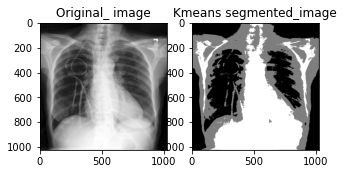

In [ ]:
[R,W]=img_enhanced.shape
cmap_0=np.where(cmap==0)
kmeans_row_0=np.floor_divide(cmap_0[0],W)
kmeans_col_0=np.mod(cmap_0[0],W)
cmap_1=np.where(cmap==1)
kmeans_row_1=np.floor_divide(cmap_1[0],W)
kmeans_col_1=np.mod(cmap_1[0],W)
cmap_2=np.where(cmap==2)
kmeans_row_2=np.floor_divide(cmap_2[0],W)
kmeans_col_2=np.mod(cmap_2[0],W)

kmeans_segmented_img_1=np.zeros(img_enhanced.shape)
kmeans_segmented_img_1[kmeans_row_0,kmeans_col_0]=V_centre[0]
kmeans_segmented_img_1[kmeans_row_1,kmeans_col_1]=V_centre[1]
kmeans_segmented_img_1[kmeans_row_2,kmeans_col_2]=V_centre[2]

plt.figure(2)
fig, axs = plt.subplots(nrows=1,ncols=2, sharex=True, figsize=(5,5))
axs[0].set_title('Original_ image')
axs[0].imshow(img_enhanced,cmap="gray")

axs[1].set_title('Kmeans segmented_image')
axs[1].imshow(kmeans_segmented_img_1,cmap="gray")
plt.show()

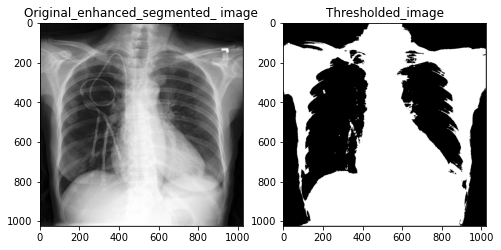

In [ ]:
# centers=np.uint8(V_centre_sorted)
# mcenter=V_centre_sorted[1]
index_body=np.where(cmap==1)
index_seg=np.where(cmap==2)
[R,W]=img_enhanced.shape
pixel_values=img_enhanced.reshape((-1,1))

mu=np.mean(pixel_values[index_body[0]])
std=np.std(pixel_values[index_body[0]])
T=mu-(0.65*std)   ###varry the thresholding value to obtain desired thresholded image

Thresh_index=np.where(pixel_values>T)
#Thresh_index=Thresh_index.reshape((-1,1))
Thresh_row=np.floor_divide(Thresh_index[0],W)
Thresh_col=np.mod(Thresh_index[0],W)
Thresholded_img=np.zeros(img_enhanced.shape)

Thresholded_img[Thresh_row,Thresh_col]=255

fig, axs = plt.subplots(nrows=1,ncols=2, sharex=True, figsize=(8,8))
axs[0].set_title('Original_enhanced_segmented_ image')
axs[0].imshow(img_enhanced,cmap="gray")

axs[1].set_title('Thresholded_image')
axs[1].imshow(Thresholded_img,cmap="gray")
plt.show()
fig.savefig('Output/test/%d/kmeans_segmented_image.png'%int(img_no+1), bbox_inches='tight')

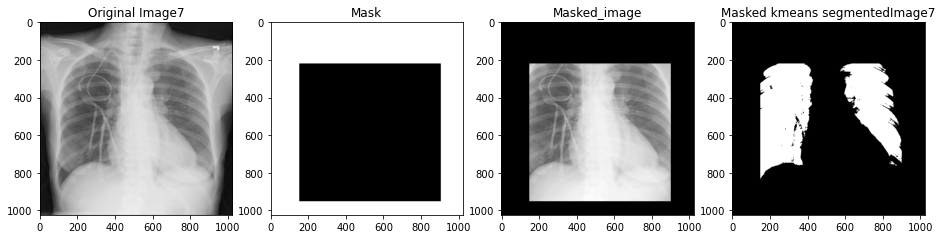

In [ ]:
from skimage import draw
# Create the basic mask
image=np.copy(Original_Image)
Basic_mask = np.ones(shape=image.shape[0:2], dtype="bool")
masked_skel=np.copy(Thresholded_img)
# Draw a filled rectangle on the mask image
#rr, cc = skimage.draw.rectangle(start=(59,59), end=(480,740))
rr, cc = skimage.draw.rectangle(start=(220,150), end=(950,900))
Basic_mask[rr, cc] = False
image[Basic_mask] = 0
masked_skel[Basic_mask] = 255
# Basic_mask=255-Basic_mask
masked_kmeans=255-masked_skel
display = [Original_Image, Basic_mask,image,masked_kmeans ]
label = ['Original Image%d'%int(img_no+1),'Mask','Masked_image','Masked kmeans segmentedImage%d'%int(img_no+1) ]

fig = plt.figure(figsize=(20,25))

for i in range(len(display)):
  fig.add_subplot(5,5, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

# fig.savefig("Output/train/%d/k_means_groundtruth.png"%int(img_no+1), bbox_inches='tight')

# Part 2: Segmentation: Create a shape prior using the ground truth, use this as initialization for Active contour model to segment the lungs.


In [ ]:
def circle_level_set(image_shape, center=None, radius=None):
    """Create a circle level set with binary values.
    Parameters
    ----------
    image_shape : tuple of positive integers
        Shape of the image
    center : tuple of positive integers, optional
        Coordinates of the center of the circle given in (row, column). If not
        given, it defaults to the center of the image.
    radius : float, optional
        Radius of the circle. If not given, it is set to the 75% of the
        smallest image dimension.
    Returns
    -------
    out : array with shape `image_shape`
        Binary level set of the circle with the given `radius` and `center`.
    See also
    --------
    checkerboard_level_set
    """

    if center is None:
        center = tuple(i // 2 for i in image_shape)

    if radius is None:
        radius = min(image_shape) * 3.0 / 8.0

    grid = np.mgrid[[slice(i) for i in image_shape]]
    grid = (grid.T - center).T
    phi = radius - np.sqrt(np.sum((grid)**2, 0))
    res = np.int8(phi > 0)
    return res

In [ ]:
def _init_level_set(init_level_set, image_shape):
    """Auxiliary function for initializing level sets with a string.
    If `init_level_set` is not a string, it is returned as is.
    """
    if isinstance(init_level_set, str):
        if init_level_set == 'checkerboard':
            res = checkerboard_level_set(image_shape)
        elif init_level_set == 'circle':
            res = circle_level_set(image_shape)
        else:
            raise ValueError("`init_level_set` not in "
                             "['checkerboard', 'circle']")
    else:
        res = init_level_set
    return res

In [ ]:
smoothing=3

class _fcycle(object):

    def __init__(self, iterable):
        """Call functions from the iterable each time it is called."""
        self.funcs = cycle(iterable)

    def __call__(self, *args, **kwargs):
        f = next(self.funcs)
        return f(*args, **kwargs)
def sup_inf(u):
    """SI operator."""

    if np.ndim(u) == 2:
        P = _P2
    elif np.ndim(u) == 3:
        P = _P3
    else:
        raise ValueError("u has an invalid number of dimensions "
                         "(should be 2 or 3)")

    erosions = []
    for P_i in P:
        erosions.append(ndi.binary_erosion(u, P_i))

    return np.array(erosions, dtype=np.int8).max(0)

# SI and IS operators for 2D and 3D.
_P2 = [np.eye(3),
       np.array([[0, 1, 0]] * 3), ####Horizontal gradient
       np.flipud(np.eye(3)),       
       np.rot90([[0, 1, 0]] * 3)]  ####vertical gradient 
def inf_sup(u):
    """IS operator."""

    if np.ndim(u) == 2:
        P = _P2
    # elif np.ndim(u) == 3:
    #     P = _P3
    else:
        raise ValueError("u has an invalid number of dimensions "
                         "(should be 2 or 3)")

    dilations = []
    for P_i in P:
        dilations.append(ndi.binary_dilation(u, P_i))

    return np.array(dilations, dtype=np.int8).min(0)
_curvop = _fcycle([lambda u: sup_inf(inf_sup(u)),   # SIoIS
                   lambda u: inf_sup(sup_inf(u))])  # ISoSI

# for _ in range(smoothing):
#             u = _curvop(u)

In [ ]:
def morphological_chan_vese(image, iterations, init_level_set='checkerboard',
                            smoothing=1, lambda1=1, lambda2=1):

                            #iter_callback=lambda x: None

    init_level_set = _init_level_set(init_level_set, image.shape)

    #_check_input(image, init_level_set)

    u = np.int8(init_level_set > 0)

    #iter_callback(u)

    for _ in range(iterations):

        # inside = u > 0
        # outside = u <= 0
        c0 = (image * (1 - u)).sum() / float((1 - u).sum() + 1e-8)  # outside contour
        c1 = (image * u).sum() / float(u.sum() + 1e-8)              #inside contour

        # Image attachment
        du = np.gradient(u)
        abs_du = np.abs(du).sum(0)
        aux = abs_du * (lambda1 * (image - c1)**2 - lambda2 * (image - c0)**2)

        u[aux < 0] = 1
        u[aux > 0] = 0

        # Smoothing
        for _ in range(smoothing):
            u = _curvop(u)

        

    return u

# Levelset generated by meanshape calculation of training data

In [ ]:
# Morphological Chan-Vese (or ACWE)
init_ls_tr = initial_level_set_tr#circle_level_set(crop_img.shape, center=(600, 250), radius=10)
Morphological_img_meanshape=morphological_chan_vese(img_enhanced, iterations=500,
                            init_level_set=init_ls_tr,
                            smoothing=3, lambda1=1, lambda2=1)

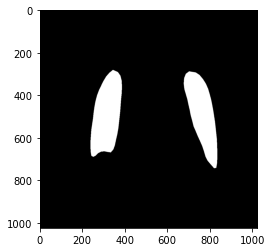

In [ ]:
plt.imshow(initial_level_set_tr,cmap='gray')

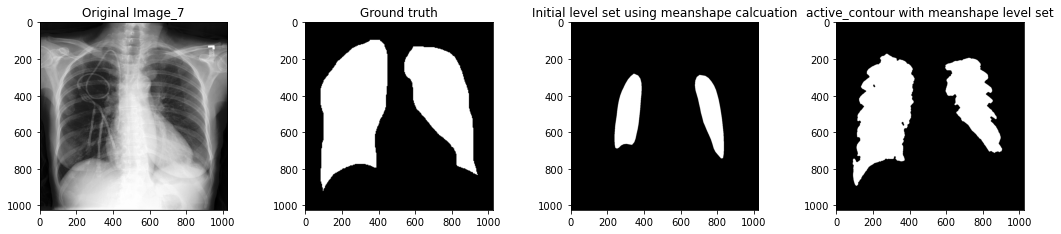

In [ ]:
display = [img_enhanced,gt_img_closing,initial_level_set_tr,Morphological_img_meanshape]
label = ['Original Image_%d'%int(img_no+1),'Ground truth','Initial level set using meanshape calcuation','active_contour with meanshape level set' ]

fig = plt.figure(figsize=(23,20))

for i in range(len(display)):
  fig.add_subplot(5,5, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()
#fig.savefig('Output/test/%d/kmeans_segmented_image.png'%int(img_no+1), bbox_inches='tight')
fig.savefig("output/test/%d/active contour segmenation with meanshape level set.png"%int(img_no+1), bbox_inches='tight')

# Circular level set as initial prior

In [ ]:
# Morphological Chan-Vese (or ACWE)
init_ls = 'circle'#circle_level_set(crop_img.shape, center=(600, 250), radius=10)
Morphological_img_circle=morphological_chan_vese(img_enhanced, iterations=500,
                            init_level_set=init_ls,
                            smoothing=3, lambda1=1, lambda2=1)

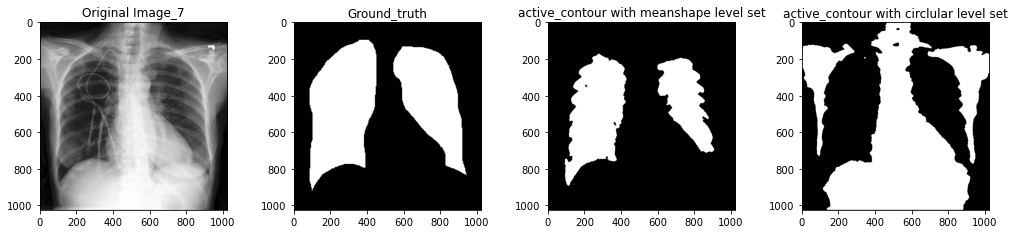

In [ ]:
display = [img_enhanced,gt_img_closing, Morphological_img_meanshape ,Morphological_img_circle]
label = ['Original Image_%d'%int(img_no+1),'Ground_truth','active_contour with meanshape level set','active_contour with circlular level set' ]

fig = plt.figure(figsize=(22,20))

for i in range(len(display)):
  fig.add_subplot(5,5, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()
# plt.imshow(Morphological_img,cmap='gray')
fig.savefig("output/test/%d/active contour segmenation with circle level set.png.png"%int(img_no+1), bbox_inches='tight')
# fig.savefig("Output/train/%d/"%int(img_no+1), bbox_inches='tight')

# k_means segmented image as initial prior

In [ ]:
# Morphological Chan-Vese (or ACWE)
init_ls = masked_kmeans#abs(255-crop_img_mask)
Morphological_img_kmeans=morphological_chan_vese(img_enhanced, iterations=50,
                            init_level_set=init_ls,
                            smoothing=3, lambda1=1, lambda2=1)

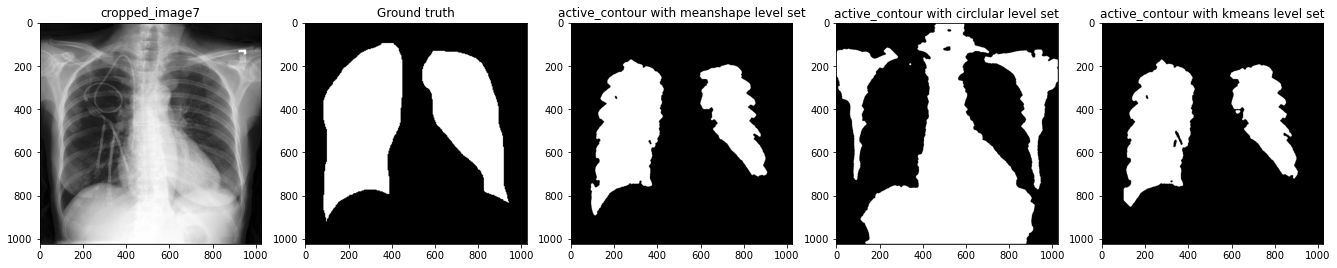

In [ ]:
display = [img_enhanced ,gt_img_closing,Morphological_img_meanshape,Morphological_img_circle,Morphological_img_kmeans]
label = ['cropped_image%d'%int(img_no+1),'Ground truth','active_contour with meanshape level set','active_contour with circlular level set','active_contour with kmeans level set' ]

fig = plt.figure(figsize=(23,25))

for i in range(len(display)):
  fig.add_subplot(5,5, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()
fig.savefig("output/test/%d/active contour segmenation with kmeans level set.png.png"%int(img_no+1), bbox_inches='tight')
# fig.savefig("Output/train/%d/active contour segmenation with kmeans level set.png"%int(img_no+1), bbox_inches='tight')

# Part 3: Validation: Compare the segmentation results with the ground truth using metrics

Supervised Method

Compare the segmentation results with the ground truth using metrics like accuracy, Dice similarity coefficient, Jaccard index (JAC), sensitivity, specificity.

In [ ]:
#DICE similarity coefficient

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
   # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())
#Jaccard coefficient

def jc(result, reference):
    """
    Jaccard coefficient
    Parameters
    ----------
    result: array_like
            Input data containing objects. Can be any type but will be converted
            into binary: background where 0, object everywhere else.
    reference: array_like
            Input data containing objects. Can be any type but will be converted
            into binary: background where 0, object everywhere else.
    jc: float
        The Jaccard coefficient between the object(s) in `result` and the
        object(s) in `reference`. It ranges from 0 (no overlap) to 1 (perfect overlap).
    """
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    
    intersection = np.count_nonzero(result & reference)
    union = np.count_nonzero(result | reference)
    
    jc = float(intersection) / float(union) #tp/tp+fn+fp
    
    return jc

#Sensitivity

def sensitivity(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
        
    tp = np.count_nonzero(result & reference)
    fn = np.count_nonzero(~result & reference)

    try:
        recall = tp / float(tp + fn)
    except ZeroDivisionError:
        recall = 0.0
    return recall

#Specificity

def specificity(result, reference):
    """
    Specificity.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    
    Returns
    -------
    specificity : float
        The specificity between two binary datasets, here mostly binary objects in images,
        which denotes the fraction of correctly returned negatives. The
        specificity is not symmetric.

    """
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
       
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)

    try:
        specificity = tn / float(tn + fp)
    except ZeroDivisionError:
        specificity = 0.0
    
    return specificity
#Accuracy

def accuracy (result, reference):
    # accuracy=(TP+TN)/(TP+FN+FP+TN)
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    tp=  np.count_nonzero(result & reference) 
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)
    fn = np.count_nonzero(~result & reference) 
    try:
        accuracy=(tp+tn)/(tp+tn+fp+fn)
    except ZeroDivisionError:
        accuracy = 0.0
    
    return accuracy

def ppv (result, reference):
    # accuracy=(TP+TN)/(TP+FN+FP+TN)
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    tp=  np.count_nonzero(result & reference) 
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)
    fn = np.count_nonzero(~result & reference) 
    try:
        ppv=(tp)/(tp+fp)
    except ZeroDivisionError:
        ppv = 0.0
    
    return ppv

Segmentation result of active contour model with Levelset generated by meanshape calculation of training data

In [ ]:
# list_segmentation_names =  sorted(Path.cwd().glob('27-20201003T050528Z-001/27/*.png'))
# Original_Image=plt.imread(str(list_img_names[img_no]))
gt_img = np.copy(gt_img_closing)
seg_img_binary = np.array(Morphological_img_meanshape)
im_alpha=np.array(seg_img_binary)
seg_img_binary[:,:] = 0
ind_seg = np.where(im_alpha==1)
seg_img_binary[ind_seg[0],ind_seg[1]] =1
gt_img_int=np.uint8(gt_img)
# # seg_img_binary=np.uint8(seg_img_binary)
reference=np.array(gt_img_int)
result=np.array(seg_img_binary)
print('accuracy is: %f'%accuracy (result, reference))
 #accuracy (result, reference))
print('specificity is: %f'%specificity(result, reference))
print('sensitivity is: %f'%sensitivity(result, reference))
print('Jaccard coefficient is: %f'%jc(result, reference))
print('Dice coefficient is: %f'%dice(result, reference))

accuracy is: 0.879489
specificity is: 0.999923
sensitivity is: 0.649203
Jaccard coefficient is: 0.649108
Dice coefficient is: 0.787223


Segmentation result of active contour model with circular level set

In [ ]:
gt_img = np.copy(gt_img_closing)
seg_img_binary = np.array(Morphological_img_circle)
im_alpha=np.array(seg_img_binary)
seg_img_binary[:,:] = 0
ind_seg = np.where(im_alpha==1)
seg_img_binary[ind_seg[0],ind_seg[1]] =1
gt_img_int=np.uint8(gt_img)
# # seg_img_binary=np.uint8(seg_img_binary)
reference=np.array(gt_img_int)
result=np.array(seg_img_binary)
print('accuracy is: %f'%accuracy (result, reference))
 #accuracy (result, reference))
print('specificity is: %f'%specificity(result, reference))
print('sensitivity is: %f'%sensitivity(result, reference))
print('Jaccard coefficient is: %f'%jc(result, reference))
print('Dice coefficient is: %f'%dice(result, reference))

accuracy is: 0.292111
specificity is: 0.355337
sensitivity is: 0.171216
Jaccard coefficient is: 0.076686
Dice coefficient is: 0.142449


Segmentation result of active contour model with kmeans based levelset

In [ ]:
gt_img = np.copy(gt_img_closing)
seg_img_binary = np.array(Morphological_img_kmeans)
im_alpha=np.array(seg_img_binary)
seg_img_binary[:,:] = 0
ind_seg = np.where(im_alpha==1)
seg_img_binary[ind_seg[0],ind_seg[1]] =1
gt_img_int=np.uint8(gt_img)
# # seg_img_binary=np.uint8(seg_img_binary)
reference=np.array(gt_img_int)
result=np.array(seg_img_binary)
print('accuracy is: %f'%accuracy (result, reference))
 #accuracy (result, reference))
print('specificity is: %f'%specificity(result, reference))
print('sensitivity is: %f'%sensitivity(result, reference))
print('Jaccard coefficient is: %f'%jc(result, reference))
print('Dice coefficient is: %f'%dice(result, reference))

accuracy is: 0.875203
specificity is: 0.999991
sensitivity is: 0.636592
Jaccard coefficient is: 0.636582
Dice coefficient is: 0.777940
